# Synthetic outbreak simulation

This notebook evaluates the ability of our regression framework to obtain robust estimates for the impact of policy on infection growth rates given the data available. Using a Monte Carlo approach, it simulates an outbreak progression using SIR and/or SEIR dynamics, allowing for noise in the $\beta$, $\gamma$, and/or $\sigma$ parameters, and allowing for $\beta$ to be affected by policy interventions. For each MC draw, it then uses our regression estimation framework to obtain estimates for the impact of those policies. We then compare the distribution of estimates with the true values, under various assumptions for the values of $\gamma$ and $\sigma$.

In [63]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import xarray as xr
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from codes import utils as cutil
from codes.models import epi

sns.set(context="paper", style="white")

out_home = cutil.RESULTS / "other" / "sims"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Defining the search space

We want to simulate over a range of population and disease parameters that are relevant to the outbreaks used in our main analysis. To do so, we first examine the values seen for these parameters across the administrative units of analysis.

In [28]:
dfs = []
for i in cutil.ISOS:
    df = pd.read_csv(cutil.MODELS / "reg_data" / f"{i}_reg_data.csv")
    name_cols = [c for c in df.columns if c.endswith("_name") and not c.startswith("adm0") and c != "adm1_adm2_name"]
    df["admX_name"] = df[name_cols].agg('_'.join, axis=1)
    df = df.drop(columns=name_cols).set_index(["adm0_name","admX_name"], drop=True)
    dfs.append(df)
reg_df = pd.concat(dfs)
reg_df["date"] = pd.to_datetime(reg_df.date)

### Population

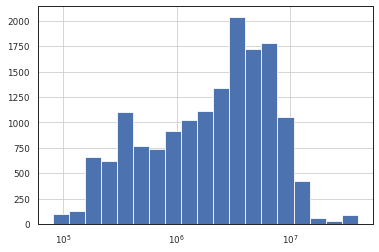

In [185]:
logbins = np.logspace(np.log10(reg_df.population).min(),np.log10(reg_df.population).max(),20)
reg_df.population.hist(bins=logbins)
plt.xscale("log")

A range between 10^5 and 10^8 seems to capture most of the admin units we study.

In [38]:
underreporting_df = pd.read_csv(cutil.DATA_INTERIM / "multi_country" / "under_reporting.csv", usecols=["country", "underreporting_estimate"], index_col="country")
underreporting_df = underreporting_df.rename(
    index={
        "China": "CHN",
        "France": "FRA",
        "Iran": "IRN",
        "Italy": "ITA",
        "South Korea": "KOR",
        "United States of America": "USA"
    }
)

In [50]:
reg_df = reg_df.join(underreporting_df, on="adm0_name")
S = 1 - (reg_df.cum_confirmed_cases / reg_df.underreporting_estimate / reg_df.population)

In [62]:
print(f"Minimum susceptible fraction observed: {S.min():.2f} ({S.idxmin()})")
print(f"p05: {S.groupby(level=[0,1]).min().quantile(.05):.2f}")

Minimum susceptible fraction observed: 0.78 (('ITA', 'Lombardia_Cremona'))
p05: 0.93


After correcting for underreporting, 95% of the admin units analyzed still finish with over 93% susceptible, indicating that the assumption of asymptotically exponential growth is reasonable. For a few admin units, the percentage of the population remaining susceptible drops below 80% at the end of the observational period used in regression.

Below, we look at a few examples of high pop/high S and low pop/low S locations

In [94]:
S_sorted = S.groupby(level=[0,1]).min().sort_values()
S_sorted = S_sorted[S_sorted.notnull()]
S_sorted.name="S"

In [95]:
Spop = pd.DataFrame(S_sorted).join(reg_df.population.drop_duplicates(), how="left")
Spop[Spop.S>.99].sort_values("population")

S  population
adm0_name admX_name                                                        
ITA       Molise_Isernia                               0.991221     84379.0
          Sardegna_Oristano                            0.996830    157707.0
          Calabria_Vibo Valentia                       0.993059    160073.0
          Sardegna_Nuoro                               0.994228    208550.0
          Sicilia_Caltanissetta                        0.992662    262458.0
...                                                         ...         ...
USA       Florida                                      0.994399  20278447.0
          Texas                                        0.997695  27419612.0
CHN       Chongqing_Chongqing                          0.999945  32756100.0
USA       California                                   0.996508  38982847.0
CHN       Sichuan_Garzê Tibetan Autonomous Prefecture  0.999917         NaN

[230 rows x 2 columns]

In [96]:
Spop[Spop.S<.8].sort_values("population")

,,S,population
adm0_name,admX_name,,
ITA,Lombardia_Cremona,0.780226,358955.0


### Length of time series

(42.54847645429363, <matplotlib.axes._subplots.AxesSubplot at 0x7fe79c412750>)

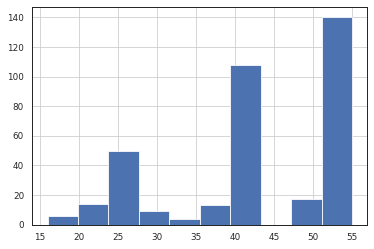

In [196]:
duration = (reg_df.groupby(level=[0,1]).date.max() - reg_df.groupby(level=[0,1]).date.min()).dt.days
duration.mean(), duration.hist()

45 days seems like a decent duration to pick for our simulations (you can play with others by turning the relevant knobs below)

### Duration of no-policy regime

Text(0.5, 1.0, 'Days to first policy from beginning of ')

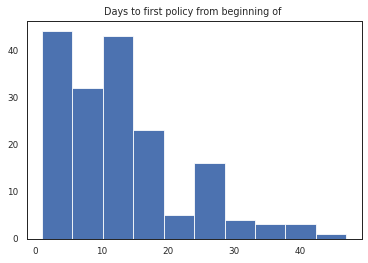

In [243]:
to_reg = reg_df.cum_confirmed_cases>10
policy_vars = reg_df.loc[to_reg,:].iloc[:,8:]
policy_vars = policy_vars[[c for c in policy_vars.columns if "testing_regime" not in c]].select_dtypes("number")

days_to_first_pol = (policy_vars>0).groupby(
    level=[0,1]
).apply(
    lambda x: x.reset_index(drop=True).idxmax(axis=0, skipna=False)
).groupby(level=0).max()
d = days_to_first_pol.values.flatten()
plt.hist(d[d>0])
plt.title('Days to first policy from beginning of regression')

Based on this analysis, we are going to set our simulations to have the first policy start sometime 10-15 days into the simulation. This corresponds to 10-15 days after the first exposure, even though we don't start the regression until there are 10 cumulative cases. This means that many policies will be starting immediately after the synthetic regression dataset begins. This provides robustness in estimating no-policy growth rates with limited no-policy observations. The figure above shows the distribution of within-country maxima for the value "days from the start of the regression to the first policy". Within each country, the maximum value across all subnational admin units is chosen.

### Reasonable noise settings

We can look at the RMSE of daily growth rates from our model predictions and use that to find a rough value that can be used to parameterize noise in the transmission rate $\beta$ in the simulations.

In [262]:
resid_files = (cutil.RESULTS / "source_data").glob("ExtendedDataFigure1_*_e.csv")
dfs = [pd.read_csv(f) for f in resid_files]
resid = pd.concat(dfs).e
rmse = np.sqrt((resid**2).mean())
rmse

0.11015891823749638

## Settings

Based on the rough diagnostics of our regression datasets depicted above, we have chosen some reasonable search parameters for this simulation exercise. You may alter them in the below cell to try out new parameter groupings.

In [6]:
# sim settings
n_days = 45
tsteps_per_day = 24
pops = [1e5, 1e6, 1e7, 1e8]
E0 = 1
I0 = 0
R0 = 0
n_samples = 1000
gamma_to_test = [0.05, 0.2, 0.33]
sigma_to_test = [0.2, 0.33, 0.5]
min_cases = 10
LHS_vars = ["I", "EI", "IR", "EIR"]
reg_lag_days = [0]
policies_to_include = ["p1", "p2", "p3"]
DGP_models = ["SIR", "SEIR"]

# policy settings
no_policy_growth_rate = 0.4

# policy effects
p_effects = [-0.05, -0.1, -0.2]
p_lags = [
    [],
    [],
    [],
]  # the effect of the lag for as many days until it reaches full effect
p_start_date = [10, 15, 20]
p_end_date = [15, 20, 25]

# stochasticity settings
beta_noise_on = True
beta_noise_sd = 0.1

gamma_noise_on = False
gamma_noise_sd = 0

sigma_noise_on = False
sigma_noise_sd = 0

In [29]:
bn, gn, sn = (0, 0, 0)
if beta_noise_on:
    bn = beta_noise_sd
if gamma_noise_on:
    gn = gamma_noise_sd
if sigma_noise_on:
    sn = sigma_noise_sd
reg_dir = out_home / f"betaNoise_{bn}_gammaNoise_{gn}_sigmaNoise_{sn}"
reg_dir.mkdir(parents=True, exist_ok=True)

## Run simulations

In [27]:
reg_res_ds = {
    "SIR": [],
    "SEIR": []
}
for m in DGP_models:
    if m=="SIR":
        this_I0 = E0
    elif m=="SEIR":
        this_I0 = I0
    for p in pops:
        reg_res_ds[m].append(
            epi.simulate_and_regress(
                p,
                no_policy_growth_rate,
                p_effects,
                p_lags,
                p_start_date,
                p_end_date,
                n_days,
                tsteps_per_day,
                n_samples,
                LHS_vars,
                reg_lag_days,
                gamma_to_test,
                beta_noise_sd,
                beta_noise_on,
                gamma_noise_sd,
                gamma_noise_on,
                min_cases,
                E0=E0,
                I0=this_I0,
                R0=R0,
                save_dir=reg_dir / m / "regression",
                sigma_to_test=sigma_to_test,
                sigma_noise_sd=sigma_noise_sd,
                sigma_noise_on=sigma_noise_on,
                kind=m
            )
        )

/home/bolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/bolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/bolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/bolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


## Regenerate predictions of cumulative cases under no-policy and policy scenarios

In [89]:
reg_ncs = [f for f in reg_dir.iterdir() if f.name[0] != "."]
pops = [int(f.name.split("_")[1]) for f in reg_ncs]
reg_res = xr.concat([xr.open_dataset(f) for f in reg_ncs], dim="pop")
reg_res["pop"] = pops
reg_res["t"] = reg_res.t.astype(int)
reg_res = reg_res.sortby("pop")

### True with-policy vals from simulation

In [135]:
true_p = reg_res[list("SEIR") + ["beta_deterministic"]]

### True no-policy counterfactual

In [6]:
def run_sim_across_pops(proj_ds, reg_res, kind):
    proj_out = []
    this_ds = proj_ds
    for p in reg_res.pop:
        if "pop" in proj_ds.dims:
            this_ds = proj_ds.sel(pop=p)
        if kind=="SEIR":
            this_out = epi.run_SEIR(
                reg_res.attrs["E0"] / p,
                reg_res.attrs["I0"] / p,
                reg_res.attrs["R0"] / p,
                this_ds,
            )
        elif kind=="SIR":
            this_out = epi.run_SIR(
                reg_res.attrs["E0"] / p,
                reg_res.attrs["R0"] / p,
                this_ds,
            )
        else:
            raise ValueError
        proj_out.append(this_out)
    out = xr.concat(proj_out, dim="pop")
    out["pop"] = reg_res.pop.values
    out["t"] = out.t.round(5)
    out = out.reindex(t=reg_res.t.astype(int))
    out.attrs = reg_res.attrs
    return out

In [95]:
tsteps_per_day = reg_res.attrs["tsteps_per_day"]
t = np.arange(0, reg_res.t.max() + 1 / tsteps_per_day, 1 / tsteps_per_day)
t = xr.DataArray(coords={"t": t}, dims=["t",], data=t)
beta_np_true = epi.get_beta_SEIR(
    xr.ones_like(t) * reg_res.attrs["no_policy_growth_rate"],
    reg_res.gamma,
    reg_res.sigma,
)
proj_ds = beta_np_true.to_dataset(name="beta_deterministic")

proj_ds = epi.get_stochastic_params(
    proj_ds,
    reg_res.attrs["beta_noise_sd"],
    bool(reg_res.attrs["beta_noise_on"]),
    reg_res.attrs["gamma_noise_sd"],
    bool(reg_res.attrs["gamma_noise_on"]),
    sigma_noise_sd=reg_res.attrs["sigma_noise_sd"],
    sigma_noise_on=bool(reg_res.attrs["sigma_noise_on"]),
)

proj_ds = epi.adjust_timescales_from_daily(proj_ds)

# # Run simulation
true_np = run_sim_across_pops(proj_ds, reg_res, "SEIR")

### Predicted states

First, we estimate gamma from the data

In [113]:
dRdt = reg_res.R.diff("t", 1)
I = ((reg_res.I.shift(t=1) + reg_res.I) / 2).isel(t=slice(1, None))
gamma_est_ds = (dRdt / I).mean(dim="t")

Then, we get our estimates of the uninhibited exponential growth rate w/ and w/o policy.

In [114]:
def get_lambda(reg_res, lagged_policy, proj_ds):
    lambda_pred_p = reg_res.Intercept.copy().broadcast_like(proj_ds)
    lambda_pred_p = lambda_pred_p.transpose("sample","t","gamma","sigma","LHS","pop")
    tmp = lambda_pred_p.values.copy()

    p_on = (reg_res.policy_timeseries > 0).argmax(dim="t").isel(pop=0).squeeze()
    for p in reg_res.policy.values:
        for l in reg_res.reg_lag.values:
            lvar = reg_res.coefficient.sel(policy=p, reg_lag=l).transpose("sample","gamma","sigma","LHS","pop").values
            for s in reg_res.sample.values:
                this_on = (
                    p_on.sel(sample=s, policy=p).item() * reg_res.attrs["tsteps_per_day"]
                )
                if lagged_policy:
                    this_on += l * reg_res.attrs["tsteps_per_day"]
                tmp[s,this_on:] += lvar[s]
    lambda_pred_p.values = tmp
    return lambda_pred_p

lambda_pred_p_SIR = get_lambda(reg_res, True, proj_ds)
lambda_pred_p_SEIR = get_lambda(reg_res, False, proj_ds)
lambda_pred_np = reg_res.Intercept.broadcast_like(lambda_pred_p_SEIR)

Then we run an SEIR and SIR model

In [116]:
def get_cum_cases_from_seir(lambda_pred, gamma_est_ds, reg_res):
    # SEIR
    beta_np_true = epi.get_beta_SEIR(
        lambda_pred,
        gamma_est_ds,
        lambda_pred.sigma.rename({"sigma": "sigma_proj"}),
    )
    proj_ds = beta_np_true.to_dataset(name="beta_deterministic")
    proj_ds["gamma_deterministic"] = gamma_est_ds

    proj_ds = epi.get_stochastic_params(
        proj_ds,
        reg_res.attrs["beta_noise_sd"],
        bool(reg_res.attrs["beta_noise_on"]),
        reg_res.attrs["gamma_noise_sd"],
        bool(reg_res.attrs["gamma_noise_on"]),
        sigma_noise_sd=reg_res.attrs["sigma_noise_sd"],
        sigma_noise_on=bool(reg_res.attrs["sigma_noise_on"]),
    )

    proj_ds = epi.adjust_timescales_from_daily(proj_ds)

    # Run simulation
    true_np_seir = run_sim_across_pops(proj_ds, reg_res, "SEIR")
    return true_np_seir

def get_cum_cases_from_sir(lambda_pred, gamma_est_ds, reg_res):
    # SIR
    proj_ds = (lambda_pred + gamma_est_ds).to_dataset(name="beta_deterministic")
    proj_ds["gamma_deterministic"] = gamma_est_ds
    proj_ds = epi.get_stochastic_params(
        proj_ds,
        reg_res.attrs["beta_noise_sd"],
        bool(reg_res.attrs["beta_noise_on"]),
        reg_res.attrs["gamma_noise_sd"],
        bool(reg_res.attrs["gamma_noise_on"]),
    ).drop("sigma_stoch")
    proj_ds = epi.adjust_timescales_from_daily(proj_ds)

    # Run simulation
    true_np_sir = run_sim_across_pops(proj_ds, reg_res, "SIR")
    return true_np_sir

Now we calculate final system state with and without policy

In [117]:
pred_p_SIR = get_cum_cases_from_sir(lambda_pred_p_SIR, gamma_est_ds, reg_res)
pred_np_SIR = get_cum_cases_from_sir(lambda_pred_np, gamma_est_ds, reg_res)
pred_p_SEIR = get_cum_cases_from_seir(lambda_pred_p_SEIR, gamma_est_ds, reg_res)
pred_np_SEIR = get_cum_cases_from_seir(lambda_pred_np, gamma_est_ds, reg_res)

Now we aggregate all of the true and pred values

In [119]:
sim_dir_base = out_home / "projection"
bn, gn, sn = (0, 0, 0)
if beta_noise_on:
    bn = reg_res.attrs["beta_noise_sd"]
if gamma_noise_on:
    gn = reg_res.attrs["gamma_noise_sd"]
if sigma_noise_on:
    sn = reg_res.attrs["sigma_noise_sd"]
    
sim_dir = sim_dir_base / f"betaNoise_{bn}_gammaNoise_{gn}_sigmaNoise_{sn}"
sim_dir.mkdir(parents=True, exist_ok=True)

In [137]:
sir_pred = xr.concat([pred_np_SIR[list("SIR")+["beta_deterministic", "gamma_deterministic"]], pred_p_SIR[list("SIR")+["beta_deterministic", "gamma_deterministic"]]], dim="with_policy")
sir_pred.to_netcdf(sim_dir / "pred_sir.nc")
seir_pred = xr.concat([pred_np_SEIR[list("SEIR")+["beta_deterministic", "gamma_deterministic"]], pred_p_SEIR[list("SEIR")+["beta_deterministic", "gamma_deterministic"]]], dim="with_policy")
seir_pred.to_netcdf(sim_dir / "pred_seir.nc")
true = xr.concat([true_np[list("SEIR")+["beta_deterministic"]], true_p[list("SEIR")+["beta_deterministic"]]], dim="with_policy")
true.to_netcdf(sim_dir / "true.nc")

# OLD STUFF BELOW!!!!

In [64]:
mean_sir = sir_pred.mean(dim="sample")
mean_seir = seir_pred.mean(dim="sample")
mean_true = true.mean(dim="sample")

In [71]:
gx = -1
sx = -1
sxp = -1

this_sir_pred = mean_sir.sel(LHS="I").isel(sigma=sx, gamma=gx)
this_sir_pred["IR"] = this_sir_pred.I + this_sir_pred.R

this_seir_pred = mean_seir.sel(LHS="I").isel(sigma=sx, gamma=gx, sigma_proj=sxp)
this_seir_pred["IR"] = this_seir_pred.I + this_seir_pred.R

this_true = mean_true.isel(sigma=sx, gamma=gx)
this_true["IR"] = this_true.I + this_true.R


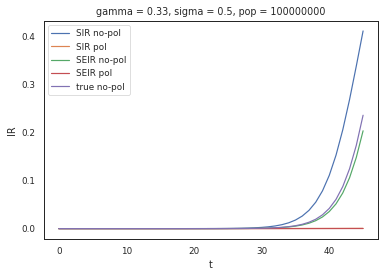

In [72]:
pop_ix = 2

lowp_sir = this_sir_pred.isel(pop=pop_ix)
lowp_seir = this_seir_pred.isel(pop=pop_ix)
lowp_true = this_true.isel(pop=pop_ix)
lowp_sir.IR.isel(with_policy=0).plot(label="SIR no-pol")
lowp_sir.IR.isel(with_policy=1).plot(label="SIR pol")
lowp_seir.IR.isel(with_policy=0).plot(label="SEIR no-pol")
lowp_seir.IR.isel(with_policy=1).plot(label="SEIR pol")
lowp_true.IR.isel(with_policy=0).plot(label="true no-pol")
# lowp_true.IR.isel(with_policy=1).plot(label="true pol")

plt.legend()

In [481]:
kind = "SIR"
if kind == "SIR":
    pred_np = pred_np_SIR
    pred_pol = pred_pol_SIR
else:
    pred_np = pred_np_SEIR
    pred_pol = pred_pol_SEIR

In [482]:
diffs = xr.Dataset({"true": true_np - true_pol})
diffs = diffs.merge((pred_np - pred_pol).to_dataset(dim="case_type"))
diffs["S_min"] = S_min
diffs["S_min_p3"] = S_min_p3
diffs.to_netcdf(
    cutil.HOME / "results" / "other" / f"{kind}_pred_estimates_diff_pop_{int(pop)}.nc"
)

rats = xr.Dataset({"true": true_pol / true_np})
rats = rats.merge((pred_pol / pred_np).to_dataset(dim="case_type"))
rats["S_min"] = S_min
rats["S_min_p3"] = S_min_p3
rats.to_netcdf(
    cutil.HOME / "results" / "other" / f"{kind}_pred_estimates_ratio_pop_{int(pop)}.nc"
)

## Plot results

In [483]:
out_dir = cutil.HOME / "results" / "figures" / "sims"
out_dir.mkdir(parents=True, exist_ok=True)

bn, gn, sn = (0, 0, 0)
if beta_noise_on:
    bn = beta_noise_sd
if gamma_noise_on:
    gn = gamma_noise_sd
if sigma_noise_on:
    sn = sigma_noise_sd

### Histograms of cases averted/delayed

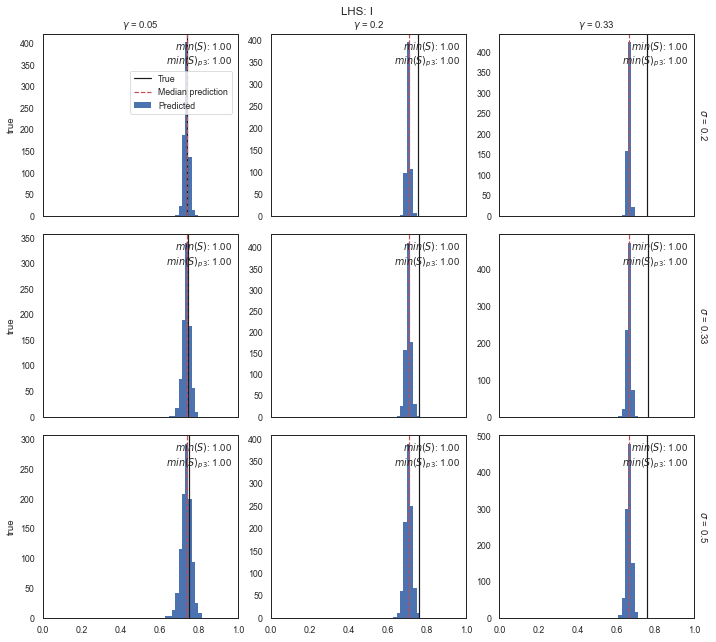

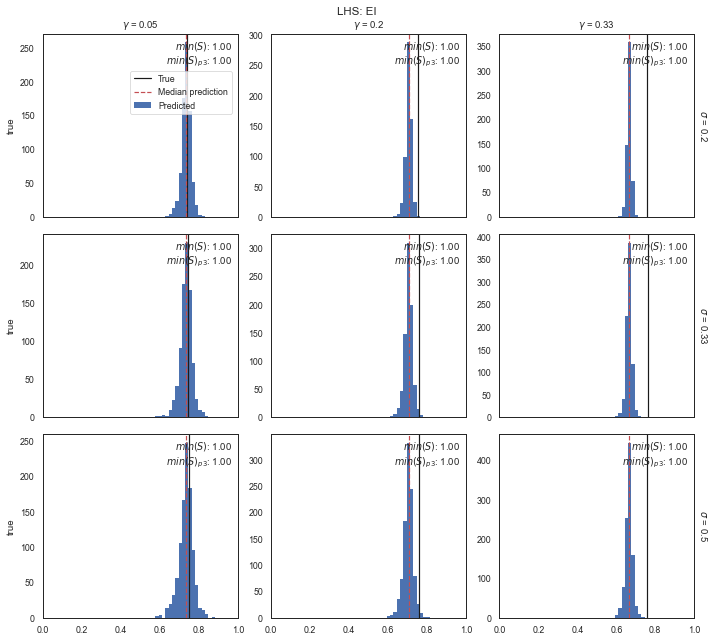

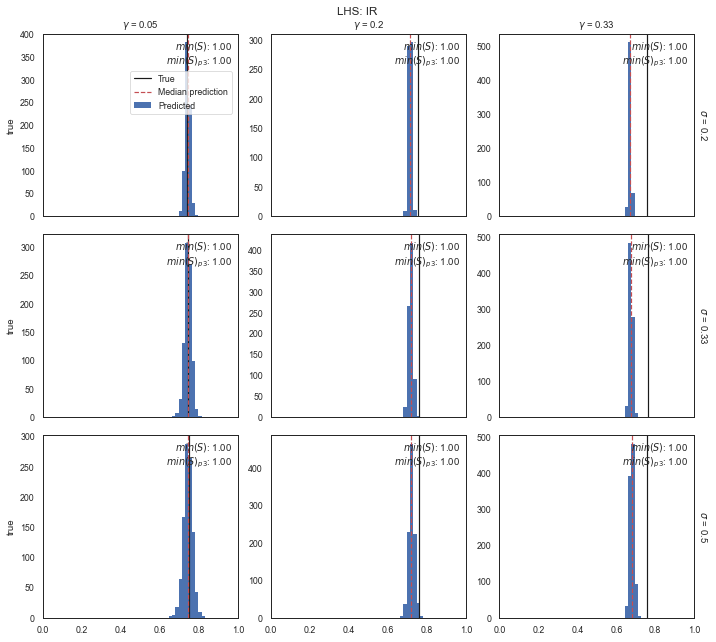

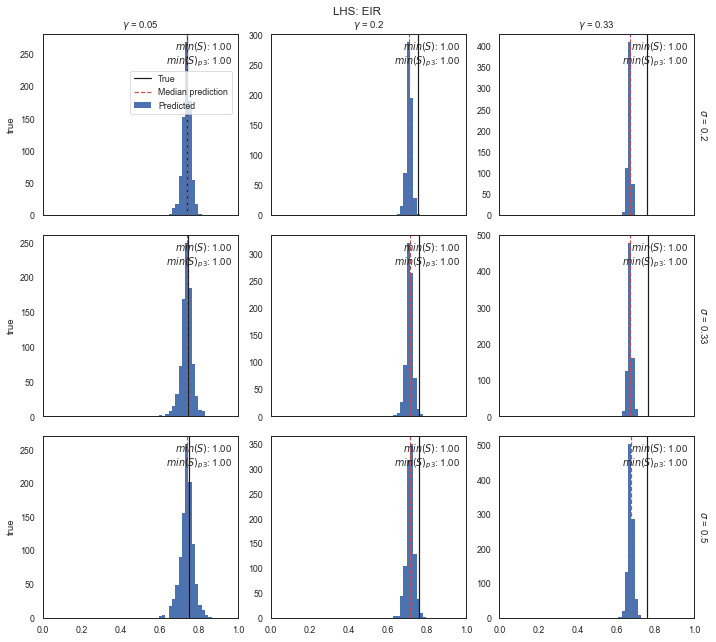

In [468]:
this_ds = diffs

if kind == "SEIR":
    sp = this_ds.sigma_proj.values
    dss = [this_ds.sel(sigma_proj=s) for s in sp]
    titles = [f", sigma_proj={s}" for s in sp]
    suffixes = [f"sp_{s}" for s in sp]
else:
    dss = [this_ds]
    titles = [""]
    suffixes = [""]
for dx, d in enumerate(dss):
    for i in LHS_vars:
        out_path = (
            out_dir
            / f"{kind}_proj_results_{i}_betaNoise_{bn}_gammaNoise_{gn}_sigmaNoise_{sn}_"
            f"pop{int(pop)}_lag_{'-'.join([str(s) for s in reg_lag_days])}_sigmaProj_{suffixes[dx]}.pdf"
        )
        g = xr.plot.FacetGrid(d, col="gamma", row="sigma", sharex=True, sharey=False)
        g.map(
            lambda x, y: plt.hist(
                x,
                bins=np.linspace(0, min(y.mean().item() * 3, 1), 60),
                label="Predicted",
                edgecolor="none",
            ),
            i,
            "true",
        )
        #         g.map(lambda x, y: plt.hist(x, label="Predicted"), i, "true")
        g.map(lambda x: plt.axvline(x.mean().item(), label="True", color="k"), "true")
        g.map(lambda x: plt.xlim(0, min(x.mean().item() * 2, 1)), "true")
        g.map(
            lambda x: plt.axvline(
                np.nanmedian(x), color="r", linestyle="--", label="Median prediction"
            ),
            i,
        )
        g.map(
            lambda x, y: plt.text(
                0.97,
                0.97,
                f"$min(S)$: {x.min().item():.2f}\n$min(S)_{{p3}}$: {y.min().item():.2f}",
                horizontalalignment="right",
                verticalalignment="top",
                transform=plt.gca().transAxes,
            ),
            "S_min",
            "S_min_p3",
        )
        g.axes.flat[0].legend(loc="upper right", bbox_to_anchor=(0.99, 0.82))
        g.set_xlabels("")
        g.set_titles("$\{coord}$ = {value}" + titles[dx])
        g.fig.suptitle(f"LHS: {i}", va="bottom", y=0.99)
#         g.fig.savefig(out_path, dpi=300, tight_layout=True, bbox_inches="tight")

### Histograms of growth rate impacts

These plots show potential bias in our estiamted parameters: The "no-policy" growth rate and the effects on that growth rate of each policy.

In [377]:
# get cumulative impact of each policy, summing over lags
p = policies_to_include[0]
plot_list = []
for p in policies_to_include:
    this_da = (
        estimates_ds[[pol for pol in estimates_ds.data_vars if pol.startswith(p + "_")]]
        .to_array(dim=p)
        .sum(dim=p, skipna=False)
    )
    this_da.name = p
    plot_list.append(this_da)
plot_ds = xr.concat(plot_list, dim="variable")
plot_ds["variable"] = policies_to_include
plot_ds = plot_ds.to_dataset(dim="variable")
for i in ["Intercept", "S_min", "S_min_p3", "cum_effect"]:
    plot_ds[i] = estimates_ds[i]
plot_ds.attrs = estimates_ds.attrs


for c in estimates_ds.case_type.values:
    for v in ["Intercept", "cum_effect"] + policies_to_include:
        out_path = (
            out_dir
            / f"SEIR_sim_reg_results_{c}_{v}_betaNoise_{bn}_gammaNoise_{gn}_sigmaNoise_{sn}_"
            f"pop{int(pop)}_lag_{'-'.join([str(s) for s in reg_lag_days])}.pdf"
        )
        g = simplot.facet_hist(plot_ds, c, v, col="gamma", row="sigma")
        g.fig.savefig(out_path, dpi=300, tight_layout=True, bbox_inches="tight")

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1193fc440> (for post_execute):


KeyboardInterrupt: 

### Convergence of cumulative cases growth to active cases growth

These plots show how the growth rates in cumulative cases converge to the growth rates in active cases under a S ~= 1 regime (assuming no policy and no noise in $\gamma$).

In [514]:
this_pop = 5e3

In [515]:
this_E0 = 0 / this_pop
this_I0 = 1 / this_pop
this_R0 = 0 / this_pop

out = np.empty(
    (len(LHS_vars), len(gamma_to_test), len(sigma_to_test), ttotal), dtype=np.float32
)
out.fill(np.nan)
coords = OrderedDict(case_type=LHS_vars, gamma=gamma_to_test, sigma=sigma_to_test, t=t)
res_da = xr.DataArray(coords=coords, dims=coords.keys(), data=out).to_dataset(
    dim="case_type"
)
for i in LHS_vars:
    res_da[i + "_logdiff"] = res_da[i].copy()
res_da["S"] = res_da["I"].copy()

# run sim
for gx, gamma in enumerate(gamma_to_test):
    for sx, sigma in enumerate(sigma_to_test):

        # get sample params
        this_beta = beta_deterministic[0, 0, gx, sx] * np.ones(ttotal) / tsteps_per_day
        this_gamma = gamma * np.ones(ttotal) / tsteps_per_day
        this_sigma = sigma * np.ones(ttotal) / tsteps_per_day

        # one policy to adjust to in the middle
        policy_on = int(ttotal / 2)
        beta_pol = beta_deterministic[0, -1, gx, sx] / tsteps_per_day
        this_beta[policy_on:] = beta_pol

        # run dynamic model
        S, E, I, R = epi.run_SEIR(
            ttotal, this_E0, this_I0, this_R0, this_beta, this_gamma, this_sigma
        )
        res_da["S"][gx, sx] = S
        res_da["I"][gx, sx] = I
        res_da["EI"][gx, sx] = I + E
        res_da["IR"][gx, sx] = I + R
        res_da["EIR"][gx, sx] = E + I + R

        for i in LHS_vars:
            a = res_da[i][gx, sx] * this_pop
            a = np.log(a).diff("t", 1)
            a["t"] = t[:-1]
            res_da[i + "_logdiff"][gx, sx, :-1] = a * tsteps_per_day
            res_da[i + "_logdiff"][gx, sx, -1] = np.nan

/Users/ianbolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


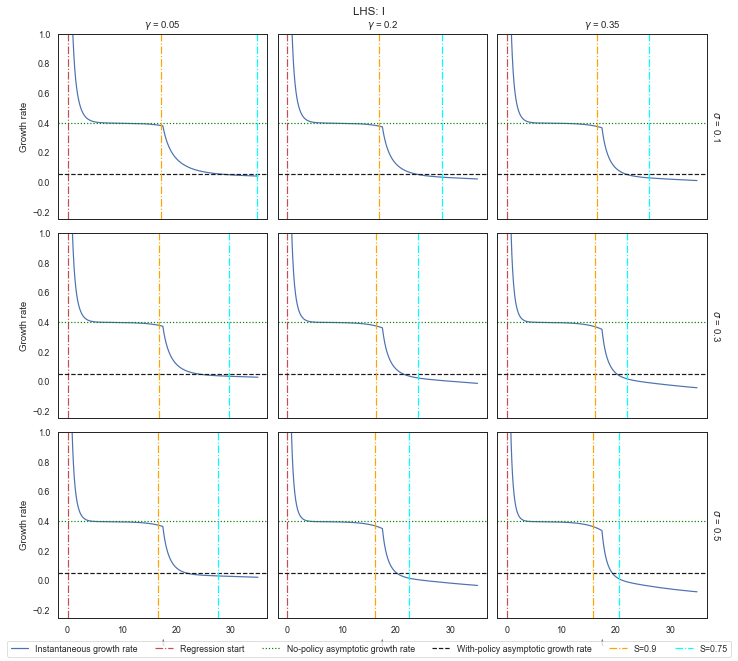

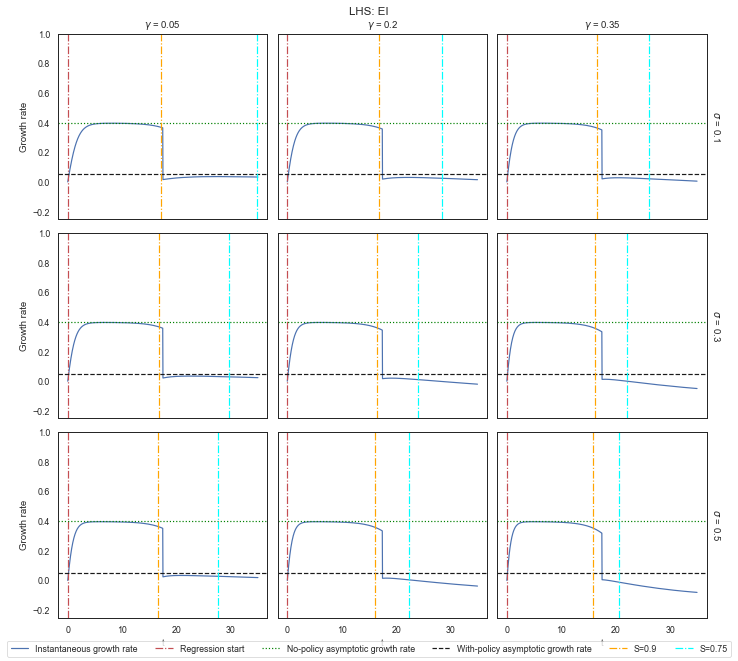

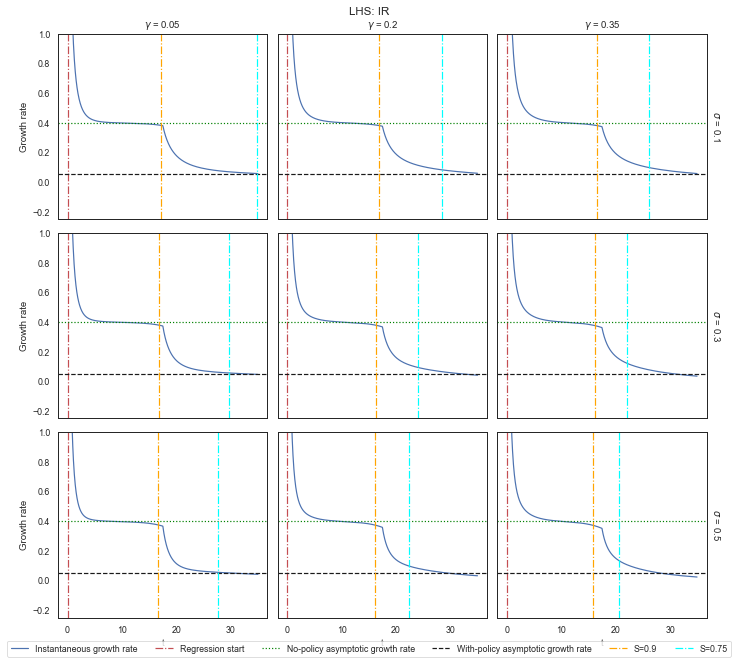

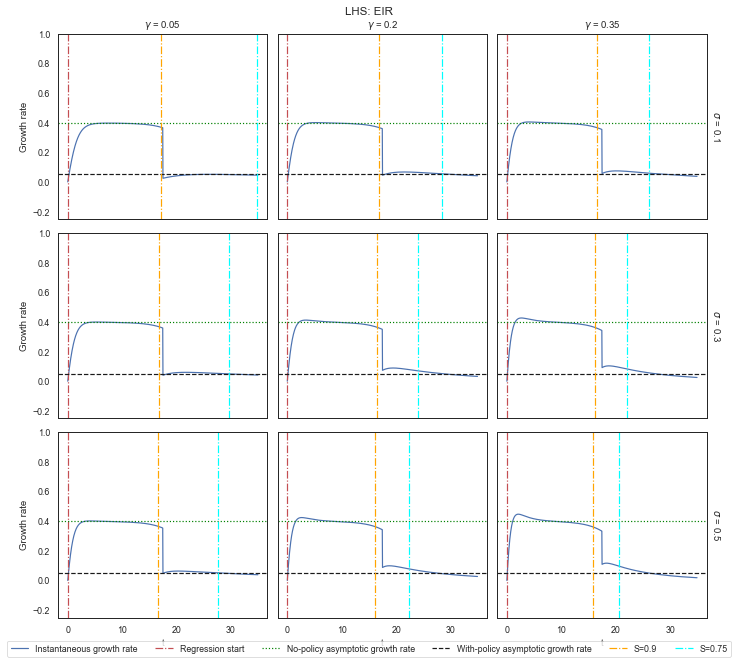

In [531]:
S_da = res_da.S
for case_type in LHS_vars:
    varname = case_type + "_logdiff"
    g = res_da[varname].plot(
        x="t",
        col="gamma",
        row="sigma",
        ylim=(-0.25, 1),
        label="Instantaneous growth rate",
    )
    for ax, namedict in zip(g.axes.flat, g.name_dicts.flat):
        casedata = res_da[case_type].loc[namedict]
        sdata = res_da.S.loc[namedict]
        ax.axvline(
            casedata.t[casedata >= (10 / pop)][0].item(),
            color="r",
            linestyle="-.",
            label="Regression start",
        )
        ax.axhline(
            no_policy_growth_rate,
            color="green",
            linestyle=":",
            label="No-policy asymptotic growth rate",
        )
        ax.axhline(
            no_policy_growth_rate + policy_effects.sum(),
            color="k",
            linestyle="--",
            label="With-policy asymptotic growth rate",
        )
        ax.axvline(
            sdata.t[sdata <= 0.9][0].item(),
            color="orange",
            linestyle="-.",
            label="S=0.9",
        )
        ax.axvline(
            sdata.t[sdata <= 0.75][0].item(),
            color="cyan",
            linestyle="-.",
            label="S=0.75",
        )
    g.fig.legend(
        *g.axes.flat[0].get_legend_handles_labels(), loc="lower center", ncol=6
    )
    g.set_titles("$\{coord}$ = {value}")
    g.set_ylabels("Growth rate")
    g.fig.suptitle(f"LHS: {case_type}", va="bottom", y=0.99)
    g.fig.savefig(
        out_dir / f"growth_sim_{case_type}_pop_{this_pop}.pdf",
        dpi=300,
        tight_layout=True,
    )